In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.optimize as opt
from scipy.linalg import expm

In [9]:
XX, YY, ZZ_norm, ZZ_re, ZZ_im = None, None, None, None, None
data = None
with open("rabi_LO_data.pkl", "rb") as f:
    data = pickle.load(f)
    XX, YY, ZZ_norm, ZZ_re, ZZ_im = data["durations"], data["shifts"], data["data_norm"], data["data_re"], data["data_im"]

# Fitting central frequency

In [309]:
central_idx = np.abs(YY[:, 0]).argmin()
durations = XX[0, :]
rabi_re = ZZ_re[central_idx, :]
rabi_im = ZZ_im[central_idx, :]

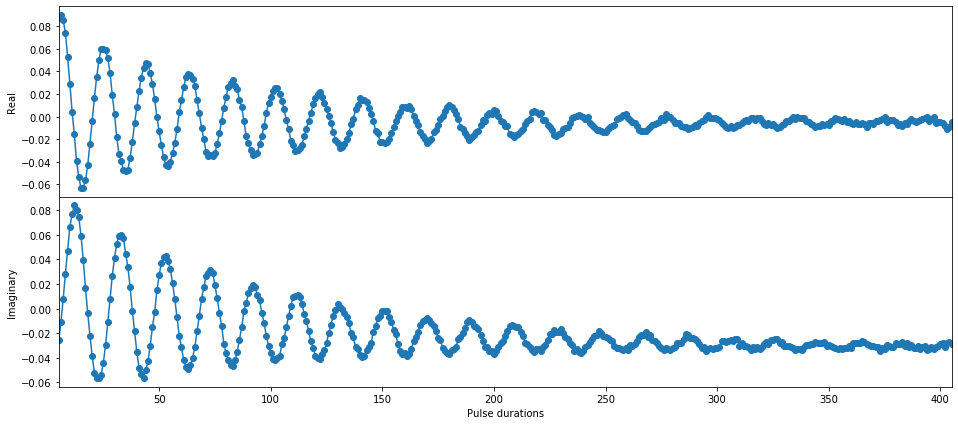

In [310]:
fig, axes = plt.subplots(2, sharex=True, figsize=(16, 7))
fig.subplots_adjust(hspace=0)

axes[0].plot(durations, rabi_re, '-o')
axes[0].set_ylabel("Real")
axes[1].plot(durations, rabi_im, '-o')
axes[1].set_ylabel("Imaginary")
axes[1].set_xlabel("Pulse durations")
axes[1].margins(x=0)

plt.show()

In [512]:
def fit_function(durations, c1, c2, c3, c4, u1, u2, u3):
    return c1 * np.exp(-u1 * durations) + (c2 * np.sin(2 * np.pi * u3 * durations) +
                                           c3 * np.cos(2 * np.pi * u3 * durations)) * np.exp(-u2 * durations) + c4

abs_re = np.max(np.abs(rabi_re))
abs_im = np.max(np.abs(rabi_im))
g_appr = np.max(np.abs(rabi_re + 1j * rabi_im))
c4_bounds = 2 * np.max(np.abs(np.mean(rabi_re + 1j * rabi_im)))
fit_bounds = (np.array([0, 0, 0, -c4_bounds, 0, 0, 0.005]),
              np.array([2*g_appr, 2*g_appr, 2*g_appr, c4_bounds, 1/100, 1/100, 2 * np.pi * 0.05]))
# fit_bounds = (np.array([-2 * np.pi * 0.01, 2 * np.pi * 0.01, 1e-5, 1e-9, 0, 0, 0, 0.9 * g_appr]),
#               np.array([2 * np.pi * 0.01, 2 * np.pi * 0.1, 1e-1, 1e-3, 1, np.pi, 2 * np.pi, 1e4]))

# guess = np.array([2 * np.pi * 1e-6, 2 * np.pi * 5e-2, 1/115, 0, 1, 0, 0, g_appr])
fit_real, cov_real = opt.curve_fit(fit_function, durations, rabi_re, bounds=fit_bounds)
fit_real, cov_real = opt.curve_fit(fit_function, durations, rabi_re, p0=fit_real, maxfev=100000, ftol=1e-10, xtol=1e-10)
# fit_imag, cov_imag = opt.curve_fit(fit_function, durations, rabi_im, bounds=fit_bounds)
fit_imag, cov_imag = opt.curve_fit(fit_function, durations, rabi_im, p0=fit_real, maxfev=100000, ftol=1e-10, xtol=1e-10)

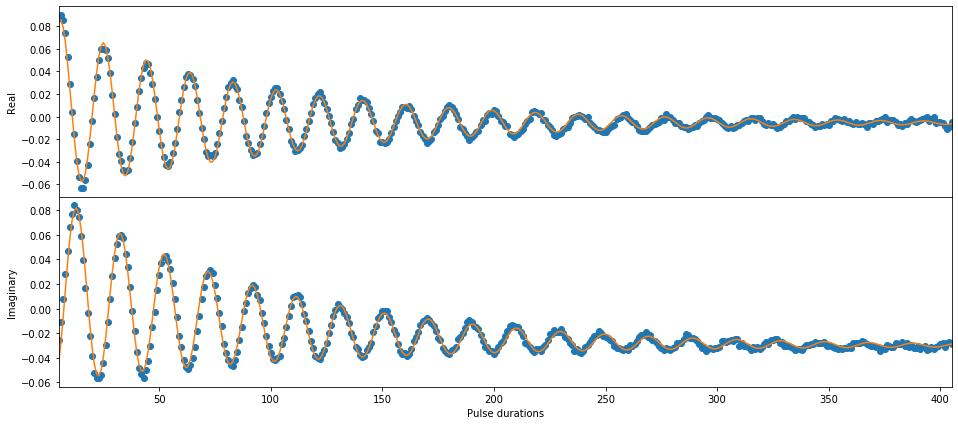

In [513]:
fig, axes = plt.subplots(2, sharex=True, figsize=(16, 7))
fig.subplots_adjust(hspace=0)

axes[0].plot(durations, rabi_re, 'o')
axes[0].plot(durations, fit_function(durations, *fit_real), '-')
axes[0].set_ylabel("Real")
axes[1].plot(durations, rabi_im, 'o')
axes[1].plot(durations, fit_function(durations, *fit_imag), '-')
axes[1].set_ylabel("Imaginary")
axes[1].set_xlabel("Pulse durations")
axes[1].margins(x=0)

plt.show()

In [508]:
c1, c2, c3, c4, g1, g2, Om = fit_real
print(f"Omega\t{Om * 1e3} MHz\n"
      f"T1\t{1/(2 * g2 - g1)} ns\n"
      f"T2\t{4/(3 * g1 - g2)} ns\n"
      f"TR\t{1/g2} ns")

Omega	51.69564371952905 MHz
T1	-93.2959964813675 ns
T2	49.354866619016995 ns
TR	102.27043398711837 ns


In [509]:
c1, c2, c3, c4, g1, g2, Om = fit_imag
print(f"Omega\t{Om * 1e3} MHz\n"
      f"T1\t{1/(2 * g2 - g1)} ns\n"
      f"T2\t{4/(3 * g1 - g2)} ns\n"
      f"TR\t{1/g2} ns")

Omega	50.69392537370972 MHz
T1	114.91299323179683 ns
T2	169.90201282530035 ns
TR	100.70556296121511 ns


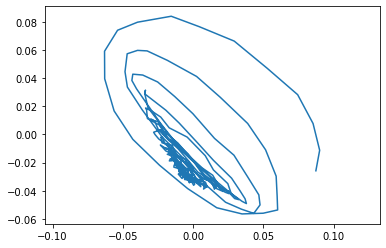

In [313]:
plt.figure()
plt.plot(rabi_re, rabi_im)
plt.axis('equal')
plt.show()

In [207]:
dw, Om, G1, gamma, r, theta, phi, g = fit_real
print(f"Detuning\t{dw * 1e3 / 2 / np.pi} MHz\n"
      f"Rabi frequency\t{Om * 1e3 / 2 / np.pi} MHz\n"
      f"T1\t{1/G1} ns\n"
      f"T2\t{1/(G1/2 + gamma)} ns\n"
      f"Photons\t{Om**2 / 4 / G1} per ns\n"
      f"x0\t{r * np.sin(theta) * np.cos(phi)}\n"
      f"y0\t{r * np.sin(theta) * np.sin(phi)}\n"
      f"z0\t{r * np.cos(theta)}\n")

Detuning	-0.6457816503840711 MHz
Rabi frequency	10.00000000000032 MHz
T1	10.0 ns
T2	19.607843137254903 ns
Photons	0.009869604401089988 per ns
x0	0.3431495414439607
y0	-3.888254149521654e-16
z0	0.9392807826654678



In [208]:
dw, Om, G1, gamma, r, theta, phi, g = fit_imag
print(f"Detuning\t{dw * 1e3 / 2 / np.pi} MHz\n"
      f"Rabi frequency\t{Om * 1e3 / 2 / np.pi} MHz\n"
      f"T1\t{1/G1} ns\n"
      f"T2\t{1/(G1/2 + gamma)} ns\n"
      f"Photons\t{Om**2 / 4 / G1} per ns\n"
      f"x0\t{r * np.sin(theta) * np.cos(phi)}\n"
      f"y0\t{r * np.sin(theta) * np.sin(phi)}\n"
      f"z0\t{r * np.cos(theta)}\n"
      f"Purity\t{r}")

Detuning	4.999999999999995 MHz
Rabi frequency	49.99999999999999 MHz
T1	50.54699825422623 ns
T2	91.8123219534568 ns
Photons	1.247197191079418 per ns
x0	0.027400258420369514
y0	-3.4519917694945576e-12
z0	0.6859383384018725
Purity	0.686485380944871


In [395]:
def fit_function(durations, dw, Om, G1, gamma, r, theta, phi, g):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    c1, c2, c3, c4, d1, d2, d3, d4, u1, u2, u3 = calc_params((dw, Om, G1, G1/2 + gamma, x, y, z, g))
    X = c1 * np.exp(u1 * durations) + (c2 * np.sin(2 * np.pi * u3 * durations) +
                                           c3 * np.cos(2 * np.pi * u3 * durations)) * np.exp(u2 * durations) + c4
    Y = d1 * np.exp(u1 * durations) + (d2 * np.sin(2 * np.pi * u3 * durations) +
                                           d3 * np.cos(2 * np.pi * u3 * durations)) * np.exp(u2 * durations) + d4
    return X + 1j * Y

def loss_function(params, args):
    durations = args[0]
    measured = args[1] + 1j * args[2]
    fit = fit_function(durations, *params)
    return np.sum(np.abs(measured - fit)**4)

g_appr = np.max(np.abs(rabi_re + 1j * rabi_im))
guess = np.array([2 * np.pi * 1e-6, 2 * np.pi * 5e-2, 1/115, 0, 1, 0, 0, g_appr])
fit_bounds = opt.Bounds(np.array([-2 * np.pi * 0.02, 2 * np.pi * 0.001, 1e-5, 0, 0, 0,     0,         1]),
              np.array([2 * np.pi * 0.02,  2 * np.pi * 0.1,  1e-1, 1e-1, 1e-2, np.pi, 2 * np.pi, 10]))
output = opt.minimize(loss_function, x0=guess,
                      args=[durations, rabi_re, rabi_im],
                      method='L-BFGS-B',
                      bounds=fit_bounds,
                      options={'disp': True})

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


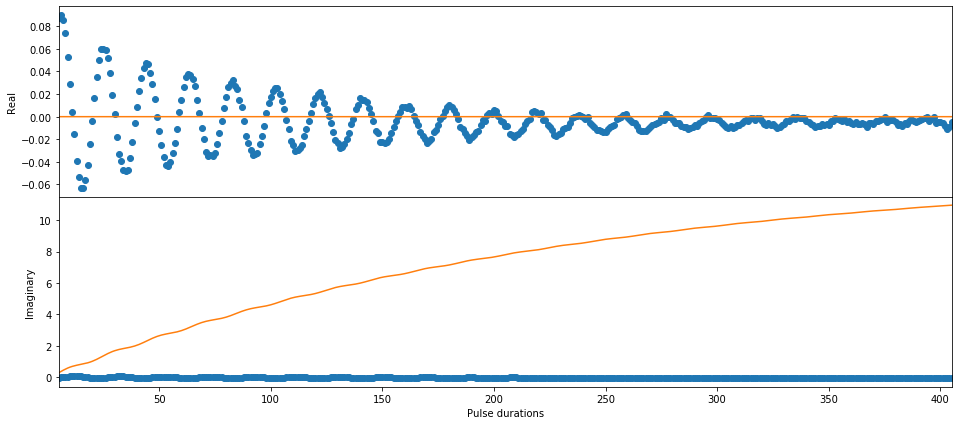

In [396]:
fig, axes = plt.subplots(2, sharex=True, figsize=(16, 7))
fig.subplots_adjust(hspace=0)

fitted = fit_function(durations, *output.x)
# guess = np.array([2 * np.pi * 1e-6, 2 * np.pi * 5e-2, 0.01, 0, 1, 0, 0, 1e3])
fitted = fit_function(durations, *guess)
axes[0].plot(durations, rabi_re, 'o')
axes[0].plot(durations, np.real(fitted), '-')
axes[0].set_ylabel("Real")
axes[1].plot(durations, rabi_im, 'o')
axes[1].plot(durations, np.imag(fitted), '-')
axes[1].set_ylabel("Imaginary")
axes[1].set_xlabel("Pulse durations")
axes[1].margins(x=0)

plt.show()

In [315]:
dw, Om, G1, gamma, r, theta, phi, g = output.x
print(f"Detuning\t{dw * 1e3 / 2 / np.pi} MHz\n"
      f"Rabi frequency\t{Om * 1e3 / 2 / np.pi} MHz\n"
      f"T1\t{1/G1} ns\n"
      f"T2\t{1/(G1/2 + gamma)} ns\n"
      f"Photons\t{Om**2 / 4 / G1} per ns\n"
      f"x0\t{r * np.sin(theta) * np.cos(phi)}\n"
      f"y0\t{r * np.sin(theta) * np.sin(phi)}\n"
      f"z0\t{r * np.cos(theta)}\n"
      f"g\t{g} mV\n")

Detuning	3.9800298992045042 MHz
Rabi frequency	51.13972335974807 MHz
T1	99999.99999999999 ns
T2	49.8932596468047 ns
Photons	2581.1693184945707 per ns
x0	0.09222256789143184
y0	0.0023663746623008132
z0	0.9952993557091573
g	1.0012308526712734 mV



In [294]:
1/(G1 + G1/2 + gamma)

59.393989512863456

In [390]:
def calc_params(params):
    dw, Om, G1, G2, x, y, z, g = params
    E3 = (12 * (dw**2 + Om**2)**3 +
         24 * (G1 - G2)**2 * (dw**2 - (5 + 3 * np.sqrt(3))/4 * Om**2) * (dw**2 - (5 - 3 * np.sqrt(3))/4 * Om**2) +
         12 * (G1 - G2)**4 * dw**2)
    E1 = np.power(-8 * (G1 - G2) * (9 * dw**2 + (G1 - G2)**2) + 36 * (G1 - G2) * Om**2 + 12 * np.sqrt(E3), 1/3)
    E2 = (dw**2 + Om**2) / 3 - (G1 - G2)**2 / 9
    l1 = E1 / 6 - 6 * E2 / E1 - G1 / 3 - 2 * G2 / 3
    l2 = -E1 / 12 + 3 * E2 / E1 - G1 / 3 - 2 * G2 / 3 + 1j * np.sqrt(3) / 2 * (E1 / 6 + 6 * E2 / E1)
    l3 = np.conj(l2)
    A = np.array([[-G2, -dw, 0, 0],
                  [dw, -G2, Om, 0],
                  [0, Om, -G1, -G1],
                  [0, 0, 0, 0]])
    I = np.eye(4)
    L1 = A.dot(A - l2 * I).dot(A - l3 * I) / (l1 * (l1 - l2) * (l1 - l3))
    L2 = A.dot(A - l1 * I).dot(A - l3 * I) / (l2 * (l2 - l1) * (l2 - l3))
    L3 = A.dot(A - l1 * I).dot(A - l2 * I) / (l3 * (l3 - l1) * (l3 - l2))
    L4 = (A - l1 * I).dot(A - l2 * I).dot(A - l3 * I) / (-l1 * l2 * l3)
    M0 = np.array([x, y, z, 1])
    c1 = g * L1.dot(M0)[0]
    c2 = g * L2.dot(M0)[0]
    c3 = g * L3.dot(M0)[0]
    c4 = g * L4.dot(M0)[0]
    d1 = g * L1.dot(M0)[1]
    d2 = g * L2.dot(M0)[1]
    d3 = g * L3.dot(M0)[1]
    d4 = g * L4.dot(M0)[1]
    u1 = l1
    u2 = np.real(l2)
    u3 = np.imag(l2) / 2 / np.pi
    return np.real(np.array([c1, c2 + c3, 1j * (c2 - c3), c4, d1, d2 + d3, 1j * (d2 - d3), d4, u1, u2, u3]))

In [464]:
from scipy.linalg import eig
def calc_params(params):
    dw, Om, G1, G2, x, y, z, g = params
    A = np.array([[-G1/2, -dw, 0, 0],
                  [dw, -G1/2, Om, 0],
                  [0, Om, -G1, -G1],
                  [0, 0, 0, 0]])
    w, vr = eig(A)
    l1, l2, l3, l4 = w
    I = np.eye(4)
    L1 = (A - l2 * I).dot(A - l3 * I).dot(A - l4 * I) / (l1 - l2) / (l1 - l3) / (l1 - l4)
    L2 = (A - l1 * I).dot(A - l3 * I).dot(A - l4 * I) / (l2 - l1) / (l2 - l3) / (l2 - l4)
    L3 = (A - l1 * I).dot(A - l2 * I).dot(A - l4 * I) / (l3 - l1) / (l3 - l2) / (l3 - l4)
    L4 = (A - l1 * I).dot(A - l2 * I).dot(A - l3 * I) / (l4 - l1) / (l4 - l2) / (l4 - l3)
    M0 = np.array([x, y, z, 1])
    c1 = g * L1.dot(M0)[0]
    c2 = g * L2.dot(M0)[0]
    c3 = g * L3.dot(M0)[0]
    c4 = g * L4.dot(M0)[0]
    d1 = g * L1.dot(M0)[1]
    d2 = g * L2.dot(M0)[1]
    d3 = g * L3.dot(M0)[1]
    d4 = g * L4.dot(M0)[1]
    return l1, l2, l3, l4, c1+1j*d1, c2+1j*d2, c3+1j*d3, c4+1j*d4

def fit_function(durations, dw, Om, G1, gamma, r_rec, theta, phi, g):
    r = 1 / (1 + r_rec**2)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    l1, l2, l3, l4, c1, c2, c3, c4 = calc_params((dw, Om, G1, G1/2 + gamma, x, y, z, g))
    XY = c1 * np.exp(l1 * durations) + c2 * np.exp(l2 * durations) + \
         c3 * np.exp(l3 * durations) + c4 * np.exp(l4 * durations)
    return XY

def loss_function(params, durations, real_data, imag_data):
    measured = real_data + 1j * imag_data
    fit = fit_function(durations, *params)
    return np.sum(np.abs(measured - fit)**4)

In [465]:
guess = np.array([1e-6, 5e-2, 1/100, 1/1000, 1, 0, 0, 1])
output = opt.minimize(loss_function, x0=guess,
                      args=(durations, rabi_re, rabi_im),
                      method='Nelder-Mead',
                      options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.001123
         Iterations: 780
         Function evaluations: 1201


In [466]:
output

 final_simplex: (array([[6.19938797e-07, 4.28412119e-04, 3.28076531e-02, 3.94114611e-05,
        1.46662251e-03, 8.82137383e-03, 2.99687512e-04, 1.07748347e+00],
       [6.19965206e-07, 4.28382789e-04, 3.28068990e-02, 3.94387954e-05,
        1.47120078e-03, 8.82081480e-03, 2.99761333e-04, 1.07755655e+00],
       [6.19931547e-07, 4.28402134e-04, 3.28076247e-02, 3.94015891e-05,
        1.46170507e-03, 8.82133700e-03, 2.99723812e-04, 1.07751290e+00],
       [6.19904936e-07, 4.28421133e-04, 3.28077406e-02, 3.93848943e-05,
        1.49399595e-03, 8.82171724e-03, 2.99766317e-04, 1.07746069e+00],
       [6.19904646e-07, 4.28429118e-04, 3.28080555e-02, 3.93794289e-05,
        1.47610013e-03, 8.82180794e-03, 2.99709712e-04, 1.07745035e+00],
       [6.19962633e-07, 4.28374739e-04, 3.28069631e-02, 3.94332672e-05,
        1.46348614e-03, 8.82081128e-03, 2.99762671e-04, 1.07756871e+00],
       [6.19918532e-07, 4.28424620e-04, 3.28076573e-02, 3.93969993e-05,
        1.48706789e-03, 8.82157418e-03, 2

In [461]:
dw, Om, G1, gamma, r, theta, phi, g = output.x
print(f"Detuning\t{dw * 1e6 / 2 / np.pi} kHz\n"
      f"Rabi frequency\t{Om * 1e3 / 2 / np.pi} MHz\n"
      f"T1\t{1/G1} ns\n"
      f"T2\t{1/(G1/2 + gamma)} ns\n"
      f"Photons\t{Om**2 / 4 / G1} per ns\n"
      f"x0\t{r * np.sin(theta) * np.cos(phi)}\n"
      f"y0\t{r * np.sin(theta) * np.sin(phi)}\n"
      f"z0\t{r * np.cos(theta)}\n"
      f"Purity\t{r}")

Detuning	0.17167856509100182 kHz
Rabi frequency	0.05993737650758629 MHz
T1	67.46863089779517 ns
T2	116.28439096109447 ns
Photons	2.392197885528952e-06 per ns
x0	0.0012693744610842064
y0	6.236348186742863e-07
z0	0.9684650839706517
Purity	0.9684659158598163


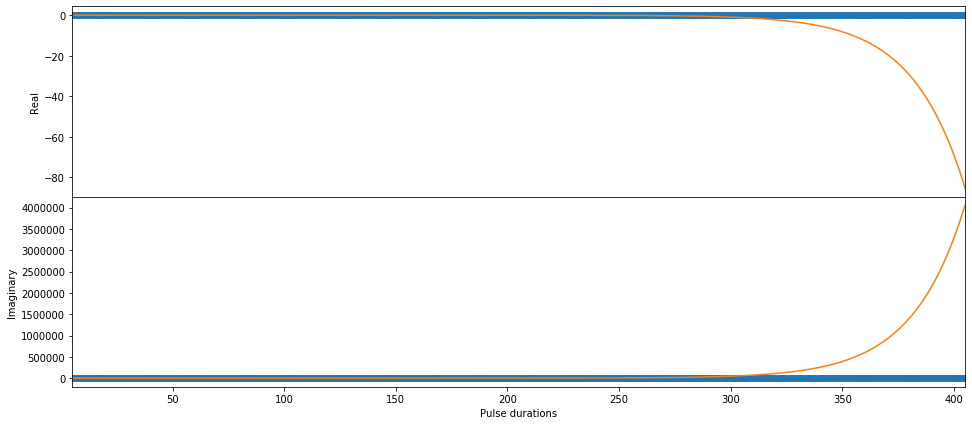

In [467]:
fig, axes = plt.subplots(2, sharex=True, figsize=(16, 7))
fig.subplots_adjust(hspace=0)

fitted = fit_function(durations, *output.x)
# guess = np.array([2 * np.pi * 1e-6, 2 * np.pi * 5e-2, 0.01, 0, 1, 0, 0, 1e3])
fitted = fit_function(durations, *guess)
axes[0].plot(durations, rabi_re, 'o')
axes[0].plot(durations, np.real(fitted), '-')
axes[0].set_ylabel("Real")
axes[1].plot(durations, rabi_im, 'o')
axes[1].plot(durations, np.imag(fitted), '-')
axes[1].set_ylabel("Imaginary")
axes[1].set_xlabel("Pulse durations")
axes[1].margins(x=0)

plt.show()

In [463]:
calc_params(output.x)

((-0.0011886419515178925+0j),
 (-0.0011784728697328416+0j),
 (-0.014832098103802505+0j),
 0j,
 (1.03244849968106-0.1082303299878027j),
 (-0.04848512042620917+0.4621648015640574j),
 (-2.2157406968435657e-06-0.028024881920485377j),
 (0.0002945248912037517-0.324577513099696j))

TypeError: fit_function() missing 1 required positional argument: 'g'

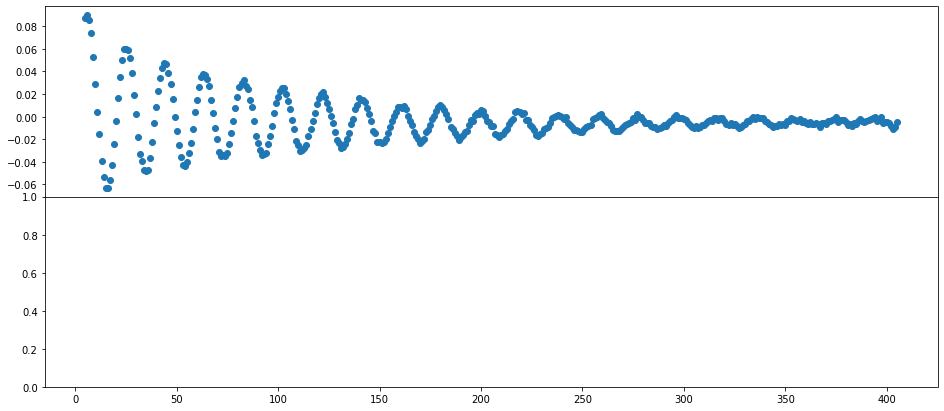

In [433]:
fig, axes = plt.subplots(2, sharex=True, figsize=(16, 7))
fig.subplots_adjust(hspace=0)

axes[0].plot(durations, rabi_re, 'o')
axes[0].plot(durations, fit_function(durations, *real_params), '-')
axes[0].set_ylabel("Real")
axes[1].plot(durations, rabi_im, 'o')
axes[1].plot(durations, fit_function(durations, *imag_params), '-')
axes[1].set_ylabel("Imaginary")
axes[1].set_xlabel("Pulse durations")
axes[1].margins(x=0)

plt.show()

# Rabi versus LO

In [515]:
shifts = YY[:, 0]
durations = XX[0, :]
# rabi_re = ZZ_re[central_idx, :]
# rabi_im = ZZ_im[central_idx, :]

In [524]:
def fit_function(durations, c1, c2, c3, c4, u1, u2, u3):
    return c1 * np.exp(-u1 * durations) + (c2 * np.sin(2 * np.pi * u3 * durations) +
                                           c3 * np.cos(2 * np.pi * u3 * durations)) * np.exp(-u2 * durations) + c4

abs_re = np.max(np.abs(rabi_re))
abs_im = np.max(np.abs(rabi_im))
g_appr = np.max(np.abs(rabi_re + 1j * rabi_im))
c4_bounds = 2 * np.max(np.abs(np.mean(rabi_re + 1j * rabi_im)))
fit_bounds = (np.array([0, 0, 0, -c4_bounds, 0, 0, 0.005]),
              np.array([2*g_appr, 2*g_appr, 2*g_appr, c4_bounds, 1/100, 1/100, 2 * np.pi * 0.05]))
# fit_bounds = (np.array([-2 * np.pi * 0.01, 2 * np.pi * 0.01, 1e-5, 1e-9, 0, 0, 0, 0.9 * g_appr]),
#               np.array([2 * np.pi * 0.01, 2 * np.pi * 0.1, 1e-1, 1e-3, 1, np.pi, 2 * np.pi, 1e4]))

# guess = np.array([2 * np.pi * 1e-6, 2 * np.pi * 5e-2, 1/115, 0, 1, 0, 0, g_appr])
OmR = np.empty_like(shifts)
for i in range(len(shifts)):
    fit_real, cov_real = opt.curve_fit(fit_function, durations, ZZ_re[i, :], bounds=fit_bounds, maxfev=10000)
    fit_real, cov_real = opt.curve_fit(fit_function, durations, ZZ_re[i, :], p0=fit_real, maxfev=100000, ftol=1e-10, xtol=1e-10)
    # fit_imag, cov_imag = opt.curve_fit(fit_function, durations, rabi_im, bounds=fit_bounds)
    fit_imag, cov_imag = opt.curve_fit(fit_function, durations, ZZ_im[i, :], p0=fit_real, maxfev=100000, ftol=1e-10, xtol=1e-10)
    OmR[i] = (fit_real[-1] + fit_imag[-1])

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


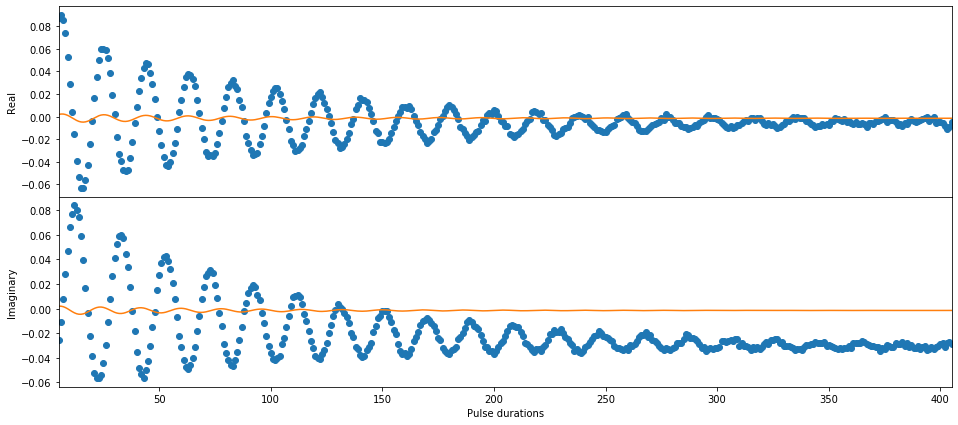

In [522]:
fig, axes = plt.subplots(2, sharex=True, figsize=(16, 7))
fig.subplots_adjust(hspace=0)

axes[0].plot(durations, rabi_re, 'o')
axes[0].plot(durations, fit_function(durations, *fit_real), '-')
axes[0].set_ylabel("Real")
axes[1].plot(durations, rabi_im, 'o')
axes[1].plot(durations, fit_function(durations, *fit_imag), '-')
axes[1].set_ylabel("Imaginary")
axes[1].set_xlabel("Pulse durations")
axes[1].margins(x=0)

plt.show()

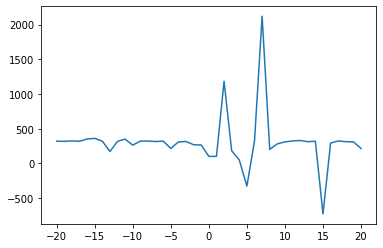

In [525]:
plt.figure()
plt.plot(shifts, OmR*1e3)
plt.show()